<a href="https://colab.research.google.com/github/Butanium/coinrun-patchs/blob/main/coinrun_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment (run once)
You just have to run this when you connect to a new environment

In [2]:
# Installing package to run coinrun (fix segfaults https://github.com/googlecolab/colabtools/issues/106)
import os
if 'LD_PRELOAD' in os.environ.keys():
  del os.environ['LD_PRELOAD']

In [3]:
%%capture
!apt-get remove libtcmalloc*
!apt-get update
!apt-get install mpich build-essential qt5-default pkg-config

In [4]:
# Download modified coinrun and model 
%%capture
!git clone --recursive https://github.com/jbkjr/objective-robustness-failures
%cd objective-robustness-failures/train-procgen-pytorch/ 
!mkdir model_data
!wget https://github.com/Butanium/coinrun-patchs/blob/main/data/coinrun.pth?raw=true -O model_data/coinrun.pth

In [5]:
%%capture
%pip install ipyplot pillow 

!pip install gym3
%cd ../procgenAISC
!python setup.py install
%cd procgen
import os, sys
sys.path.append(os.getcwd())
%cd ../../train-procgen-pytorch

# ⚠️ Restart the environment (CTRL + M .) in order to have your path updated
After that you can run the rest of the code

In [1]:
%cd objective-robustness-failures/train-procgen-pytorch/

/content/objective-robustness-failures/train-procgen-pytorch


# Sanity check
You should be able to import the procgen module

In [14]:
import procgen

# CoinRun environment code and utils

## Imports

In [3]:
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy
from common import set_global_seeds, set_global_log_levels

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch
import json
import numpy as np

## Load agent
Legacy from Lauro's code


In [4]:
def load_env_and_agent(exp_name,
                       num_envs,
                       model_file,
                       start_level,
                       num_levels,
                       distribution_mode="hard",
                       param_name="hard",
                       device="cpu",
                       gpu_device=0,
                       random_percent=0,
                       logdir=None,
                       num_threads=10):

    env_name = "coinrun"

    ####################
    ## HYPERPARAMETERS #
    ####################
    with open('hyperparams/procgen/config.yml', 'r') as f:
        hyperparameters = yaml.safe_load(f)[param_name]

    ############
    ## DEVICE ##
    ############
    if device == 'gpu':
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    #################
    ## ENVIRONMENT ##
    #################
    def create_venv(hyperparameters):
        venv = ProcgenEnv(num_envs=num_envs,
                        env_name=env_name,
                        num_levels=num_levels,
                        start_level=int(start_level),
                        distribution_mode=distribution_mode,
                        num_threads=num_threads,
                        random_percent=random_percent)
        venv = VecExtractDictObs(venv, "rgb")
        normalize_rew = hyperparameters.get('normalize_rew', True)
        if normalize_rew:
            venv = VecNormalize(venv, ob=False) # normalizing returns, but not
            #the img frames
        venv = TransposeFrame(venv)
        venv = ScaledFloatFrame(venv)
        return venv
    n_steps = hyperparameters.get('n_steps', 256)

    env = create_venv(hyperparameters)

    ############
    ## LOGGER ##
    ############
    logger = Logger(num_envs, "./logs")

    ###########
    ## MODEL ##
    ###########
    observation_space = env.observation_space
    observation_shape = observation_space.shape
    architecture = hyperparameters.get('architecture', 'impala')
    in_channels = observation_shape[0]
    action_space = env.action_space

    # Model architecture
    if architecture == 'nature':
        model = NatureModel(in_channels=in_channels)
    elif architecture == 'impala':
        model = ImpalaModel(in_channels=in_channels)

    # Discrete action space
    recurrent = hyperparameters.get('recurrent', False)
    if isinstance(action_space, gym.spaces.Discrete):
        action_size = action_space.n
        policy = CategoricalPolicy(model, recurrent, action_size)
    else:
        raise NotImplementedError
    policy.to(device)

    #############
    ## STORAGE ##
    #############
    hidden_state_dim = model.output_dim
    storage = Storage(observation_shape, hidden_state_dim, n_steps, num_envs, device)

    ###########
    ## AGENT ##
    ###########
    algo = hyperparameters.get('algo', 'ppo')
    if algo == 'ppo':
        from agents.ppo import PPO as AGENT
    else:
        raise NotImplementedError
    agent = AGENT(env, policy, logger, storage, device, 0, **hyperparameters)

    agent.policy.load_state_dict(torch.load(model_file, map_location=device)["model_state_dict"])
    agent.n_envs = num_envs
    return agent

In [5]:
def load_episode(exp_name, level_seed, model_file, **kwargs):
    """Load a single coinrun level with fixed seed. Same level layout after reset
    logdir is just for agent logs."""
    return load_env_and_agent(
        exp_name=exp_name,
        num_envs=1,
        model_file=model_file,
        num_levels=1,
        start_level=level_seed,
        num_threads=1, **kwargs
       )

## Hook abstract class

In [6]:
from abc import ABC, abstractmethod

class Hook(ABC):
  @abstractmethod
  def __call__(self, obs: np.ndarray, agent)-> np.ndarray:
    return obs

## CoinRun code
Legacy from Lauro's code


In [26]:
def run_env(
    exp_name,
    model_file,
    level_seed,
    hook : Hook = None,
    logfile=None,
    reset_mode="off", 
    max_num_timesteps=10_000,
    save_value=False,
    **kwargs):
    """
    Runs one coinrun level.
    Reset modes:
        - inv_coin returns when agent gets the inv coin OR finishes the level
        - complete returns when the agent finishes the level
        - off resets only when max_num_timesteps is reached (repeating always the same level)
    
    returns level metrics. If logfile (csv) is supplied, metrics are also
    appended there.
    """
    if save_value:
        raise NotImplementedError
    append_to_csv = False
    if logfile is not None:
        append_to_csv = True

    agent = load_episode(exp_name, level_seed, model_file, **kwargs)
    
    obs = agent.env.reset()
    hidden_state = np.zeros((agent.n_envs, agent.storage.hidden_state_size))
    done = np.zeros(agent.n_envs)


    def log_to_csv(metrics):
        """write metrics to csv"""
        if not metrics:
            return
        column_names = ["seed", "steps", "rand_coin", "coin_collected", "inv_coin_collected", "died", "timed_out"]
        metrics = [int(m) for m in metrics]
        if append_to_csv:
            with open(logfile, "a") as f:
                w = csv.writer(f)
                if f.tell() == 0: # write header first
                    w.writerow(column_names)
                w.writerow(metrics)


    def log_metrics(done: bool, info: dict):
        """
        When run complete, log metrics in the 
        following format:
        seed, steps, randomize_goal, collected_coin, collected_inv_coin, died, timed_out
        """
        metrics = None
        if done:
            keys = ["prev_level_seed", "prev_level/total_steps", "prev_level/randomize_goal", "prev_level_complete", "prev_level/invisible_coin_collected"]
            # Fix unbound key error TODO: why is /total_steps not set ?
            keys = [k for k in keys if k in info.keys()]
            metrics = [info[key] for key in keys]
            if info["prev_level_complete"]:
                metrics.extend([False, False])
            else:
                timed_out = info["prev_level/total_steps"] > 999
                metrics.extend([not timed_out, timed_out])
        elif info["invisible_coin_collected"]:
            keys = ["level_seed", "total_steps", "randomize_goal"]
            metrics = [info[key] for key in keys]
            metrics.extend([-1, True, -1, -1])
        else:
            raise
        if append_to_csv:
          log_to_csv(metrics)
        return metrics


    def check_if_break(done: bool, info: dict):
        if reset_mode == "inv_coin":
            return done or info["invisible_coin_collected"]
        elif reset_mode == "complete":
            return done
        elif reset_mode == "off":
            return False
        else:
            raise ValueError("Reset mode must be one of inv_coin, complete, off."
                             f"Instead got {reset_mode}")

    step = 0
    if hook is None:
      hook = lambda obs, *args : obs
    while step < max_num_timesteps:
        agent.policy.eval()
        for _ in range(agent.n_steps):  # = 256
            step += 1
            act, log_prob_act, value, next_hidden_state = agent.predict(obs, hidden_state, done)
            next_obs, rew, done, info = agent.env.step(act)

            agent.storage.store(obs, hidden_state, act, rew, done, info, log_prob_act, value)
            hooked_obs = hook(next_obs, agent)
            if hooked_obs.shape != obs.shape:
              raise ValueError("your hook changes the obs shape")
            obs : np.ndarray = hooked_obs
            hidden_state = next_hidden_state

            if check_if_break(done[0], info[0]):
                log_metrics(done[0], info[0])
                return
    return


## Utils

In [8]:
import matplotlib.pyplot as plt
import ipyplot
from PIL import Image
# Activate widgets in google colab
import ipywidgets as widgets
import IPython.display as display
from google.colab import output
output.enable_custom_widget_manager()


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [87]:
def plot_images(img_arrays, max_images=20, img_width=150):
  ipyplot.plot_images(img_arrays, max_images=max_images, img_width=img_width)

def obs_to_img(obs):
  return np.uint8(np.einsum('cwh -> whc', obs)* 255)
def plot_img(img, size=(250,250)):
  display.display(Image.fromarray(img).resize(size))
def slider_of_imgs(imgs):
  min_val = 0
  max_val = len(imgs) - 1

  # Create a slider widget
  slider = widgets.IntSlider(min=min_val, max=max_val, continuous_update=True)

  # Define a function to display the current image based on the slider value
  def on_value_change(change):
      index = change['new']
      img_array = imgs[index]
      # Create a PIL image from the numpy array
      img = Image.fromarray(np.uint8(img_array)).resize((250,250))
      # Display the image
      display.clear_output(wait=True)
      display.display(img)
      display.display(slider)

  # Call the on_value_change function when the slider value changes
  slider.observe(on_value_change, names='value')

  # Display the initial image
  display.display(Image.fromarray(np.uint8(imgs[0])).resize((250,250)))

  # Display the slider widget
  display.display(slider)


# Image patching

In [97]:
def patch_img(img, pos, patch):
  # Check if the position is valid
  if pos[0] < 0 or pos[0] >= img.shape[1] or pos[1] < 0 or pos[1] >= img.shape[2]:
    raise ValueError("invalid position")
  # Check if the patch is valid
  if pos[0] + patch.shape[1] > img.shape[1] or pos[1] + patch.shape[2] > img.shape[2]:
    raise ValueError("invalid position / dim")
  img[:, pos[0]:pos[0] + patch.shape[1], pos[1]:pos[1] + patch.shape[2]] = patch
  return img

def get_all_patched(img, pos, patchs):
  return list(map(lambda p : patch_img(img, pos, p), patchs))

def get_patch(img, pos, dim):
  x,y = pos[0], pos[1]
  return img[:, x:x + dim[0], y:y + dim[1]]


class Patcher:
  def __init__(self, dataset):
    self.dataset = dataset
  
  def create_patchs(self, dim, patch_per_image, dataset_stride=1):
    """
    Create patchs from a dataset
    :param dim: dimension of the patch
    :param patch_per_image: the amount of patch per image
    :param dataset_stride: dataset // dataset_stride images will be used
    :return: a list of patchs
    """
    patchs = []
    d_size = len(self.dataset)
    start = random.randint(0, min(d_size, dataset_stride) - 1)
    for i in range(start, d_size, dataset_stride):
      img = self.dataset[i]
      if patch_per_image is None:
        for x in range(0, img.shape[1] - dim[0], dim[0]):
          for y in range(0, img.shape[2] - dim[1], dim[1]):
            patchs.append(img[:, x:x + dim[0], y:y + dim[1]])
      else:
        for _ in range(patch_per_image):
          x = random.randint(0, img.shape[1] - dim[0])
          y = random.randint(0, img.shape[2] - dim[1])
          patchs.append(img[:, x:x + dim[0], y:y + dim[1]])
    return patchs

# Experiments

## Collect data with a hook

In [77]:
class ObsHook(Hook):
  def __init__(self, saveRate : int):
    self.saveRate = saveRate
    self.current = 0
    self.saves = []
    self.agent = None
  
  def __call__(self, obs : np.ndarray, agent) -> np.ndarray:
      if self.agent is None:
        self.agent = agent
      self.current += 1
      if self.current >= self.saveRate:
        self.current = 0
        self.saves.append(obs)
      return obs

  def end(self):
    plotable = list(map(lambda obs : obs_to_img(obs[0]), self.saves))
    self.plotable = np.array(plotable)
    slider_of_imgs(self.plotable)

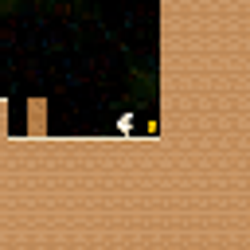

IntSlider(value=94, max=96)

In [78]:
hook = ObsHook(1)
run_env("test experiment", "model_data/coinrun.pth", 0xc0ffee, hook=hook, max_num_timesteps=1000, reset_mode="complete")
observations = hook.saves
hook.end()

## Perform patching

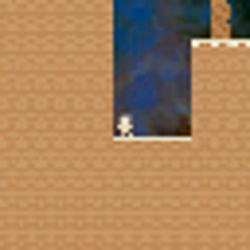

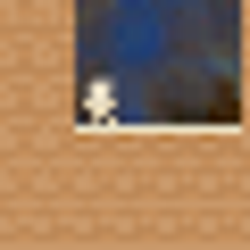

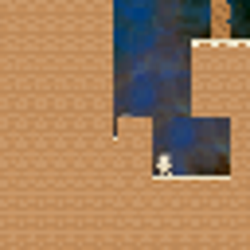

In [107]:
img = observations[0][0]
patch = get_patch(img, (20,20), (30,30))
plot_img(obs_to_img(img))
plot_img(obs_to_img(patch))
patched = patch_img(img, (30,30), patch)
plot_img(obs_to_img(patched))